# Gold DOWN Classifier - Attempt 1

**Architecture**: XGBoost binary:logistic + optional focal loss  
**Features**: 18 NEW features (different from regression model's 24)  
**Purpose**: Detect DOWN days to ensemble with regression meta-model (attempt 7)  

The regression model has 96% bullish bias - it catches 20/21 UP days but only 1/10 DOWN days.  
This classifier uses volatility regime shifts, cross-asset stress, and reversal signals to improve DOWN detection.

In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import json
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Install required packages
import subprocess
try:
    import xgboost as xgb
except ImportError:
    subprocess.run(["pip", "install", "xgboost"], check=True)
    import xgboost as xgb

try:
    import optuna
except ImportError:
    subprocess.run(["pip", "install", "optuna"], check=True)
    import optuna

from sklearn.metrics import (
    balanced_accuracy_score, recall_score, precision_score, 
    f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt

# Configuration
RANDOM_SEED = 42
N_TRIALS = 100
TIMEOUT = 3600  # 1 hour
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

# Set random seeds
np.random.seed(RANDOM_SEED)

print("="*80)
print("Gold DOWN Classifier - Attempt 1")
print("="*80)
print(f"Start time: {datetime.now().isoformat()}")
print(f"Configuration: {N_TRIALS} trials, seed={RANDOM_SEED}")
print()

Gold DOWN Classifier - Attempt 1
Start time: 2026-02-18T02:50:26.390703
Configuration: 100 trials, seed=42



In [2]:
# Cell 2: Data Fetching and Preprocessing
# This embeds the complete data fetching function from src/fetch_classifier.py

def fetch_and_preprocess():
    """
    Fetch all data sources and compute 18 classifier features.
    Returns: train_df, val_df, test_df, full_df (each with 18 features + target)
    """
    
    # Import libraries
    try:
        import yfinance as yf
        from fredapi import Fred
    except ImportError:
        import subprocess
        subprocess.run(["pip", "install", "yfinance", "fredapi"], check=True)
        import yfinance as yf
        from fredapi import Fred
    
    # Get FRED API key (Kaggle Secrets with hardcoded fallback)
    api_key = os.environ.get('FRED_API_KEY')
    if api_key is None:
        # Hardcoded fallback for Kaggle
        api_key = "3ffb68facdf6321e180e380c00e909c8"
        print("WARNING: Using hardcoded FRED_API_KEY")
    
    fred = Fred(api_key=api_key)
    
    # Fetch raw data
    START_DATE = "2014-01-01"  # 1 year extra for warmup
    
    print("Fetching yfinance data...")
    
    # GC=F: Gold futures (OHLCV)
    gc = yf.download('GC=F', start=START_DATE, progress=False, auto_adjust=True)
    if isinstance(gc.columns, pd.MultiIndex):
        gc.columns = [col[0] for col in gc.columns]
    gc = gc[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    gc.columns = [f'GC_{col}' for col in gc.columns]
    
    # GLD: Gold ETF (for volume features)
    gld = yf.download('GLD', start=START_DATE, progress=False, auto_adjust=True)
    if isinstance(gld.columns, pd.MultiIndex):
        gld.columns = [col[0] for col in gld.columns]
    gld = gld[['Volume']].copy()
    gld.columns = ['GLD_Volume']
    
    # SI=F: Silver futures
    si = yf.download('SI=F', start=START_DATE, progress=False, auto_adjust=True)
    if isinstance(si.columns, pd.MultiIndex):
        si.columns = [col[0] for col in si.columns]
    si = si[['Close']].copy()
    si.columns = ['SI_Close']
    
    # HG=F: Copper futures
    hg = yf.download('HG=F', start=START_DATE, progress=False, auto_adjust=True)
    if isinstance(hg.columns, pd.MultiIndex):
        hg.columns = [col[0] for col in hg.columns]
    hg = hg[['Close']].copy()
    hg.columns = ['HG_Close']
    
    # DX-Y.NYB: Dollar Index
    dxy = yf.download('DX-Y.NYB', start=START_DATE, progress=False, auto_adjust=True)
    if isinstance(dxy.columns, pd.MultiIndex):
        dxy.columns = [col[0] for col in dxy.columns]
    dxy = dxy[['Close']].copy()
    dxy.columns = ['DXY_Close']
    
    # ^GSPC: S&P 500
    spx = yf.download('^GSPC', start=START_DATE, progress=False, auto_adjust=True)
    if isinstance(spx.columns, pd.MultiIndex):
        spx.columns = [col[0] for col in spx.columns]
    spx = spx[['Close']].copy()
    spx.columns = ['SPX_Close']
    
    print("Fetching FRED data...")
    
    # FRED series
    gvz = pd.DataFrame({'GVZ': fred.get_series('GVZCLS', observation_start=START_DATE)})
    vix = pd.DataFrame({'VIX': fred.get_series('VIXCLS', observation_start=START_DATE)})
    dfii10 = pd.DataFrame({'DFII10': fred.get_series('DFII10', observation_start=START_DATE)})
    dgs10 = pd.DataFrame({'DGS10': fred.get_series('DGS10', observation_start=START_DATE)})
    
    # Convert index to datetime
    for df in [gvz, vix, dfii10, dgs10]:
        df.index = pd.to_datetime(df.index)
    
    # Merge all data
    print("Merging data sources...")
    
    df = gc.copy()
    for data in [gld, si, hg, dxy, spx, gvz, vix, dfii10, dgs10]:
        df = df.join(data, how='left')
    
    # Forward-fill missing values
    fred_cols = ['GVZ', 'VIX', 'DFII10', 'DGS10']
    for col in fred_cols:
        df[col] = df[col].ffill(limit=5)
    
    yf_cols = [col for col in df.columns if col not in fred_cols]
    for col in yf_cols:
        df[col] = df[col].ffill(limit=3)
    
    # Drop any remaining NaN rows
    df = df.dropna()
    
    print(f"Merged data: {len(df)} rows, {len(df.columns)} columns")
    
    # Helper functions
    def rolling_zscore(series, window=60):
        mean = series.rolling(window).mean()
        std = series.rolling(window).std()
        return (series - mean) / std.clip(lower=1e-8)
    
    def rolling_beta(y, x, window=20):
        cov = y.rolling(window).cov(x)
        var = x.rolling(window).var()
        return cov / var.clip(lower=1e-8)
    
    # Compute features
    print("Computing features...")
    
    # Gold return (for target and some features)
    df['gold_return'] = df['GC_Close'].pct_change() * 100
    
    # Category A: Volatility Regime Features (5)
    rv_10 = df['gold_return'].rolling(10).std()
    rv_30 = df['gold_return'].rolling(30).std()
    df['rv_ratio_10_30'] = rv_10 / rv_30.clip(lower=1e-8)
    df['rv_ratio_10_30_z'] = rolling_zscore(df['rv_ratio_10_30'], 60)
    df['gvz_level_z'] = rolling_zscore(df['GVZ'], 60)
    df['gvz_vix_ratio'] = df['GVZ'] / df['VIX'].clip(lower=1e-8)
    
    daily_range = (df['GC_High'] - df['GC_Low']) / df['GC_Close'].clip(lower=1e-8)
    avg_range = daily_range.rolling(20).mean()
    df['intraday_range_ratio'] = daily_range / avg_range.clip(lower=1e-8)
    
    # Category B: Cross-Asset Stress Features (4)
    vix_change = df['VIX'].pct_change() * 100
    dxy_change = df['DXY_Close'].pct_change() * 100
    spx_return = df['SPX_Close'].pct_change() * 100
    yield_change = df['DGS10'].diff()
    
    vix_z = rolling_zscore(vix_change, 20)
    dxy_z = rolling_zscore(dxy_change, 20)
    spx_z = rolling_zscore(spx_return, 20)
    yield_z = rolling_zscore(yield_change, 20)
    
    df['risk_off_score'] = vix_z + dxy_z - spx_z - yield_z
    
    gold_5d_ret = df['GC_Close'].pct_change(5) * 100
    silver_5d_ret = df['SI_Close'].pct_change(5) * 100
    divergence = gold_5d_ret - silver_5d_ret
    df['gold_silver_ratio_change'] = rolling_zscore(divergence, 60)
    
    df['equity_gold_beta_20d'] = rolling_beta(df['gold_return'], spx_return, 20)
    
    copper_5d_ret = df['HG_Close'].pct_change(5) * 100
    divergence_copper = gold_5d_ret - copper_5d_ret
    df['gold_copper_ratio_change'] = rolling_zscore(divergence_copper, 60)
    
    # Category C: Rate and Currency Shock Features (3)
    rate_change = df['DFII10'].diff()
    rate_std_20 = rate_change.rolling(20).std()
    df['rate_surprise'] = np.abs(rate_change) / rate_std_20.clip(lower=1e-8)
    df['rate_surprise_signed'] = np.sign(rate_change) * df['rate_surprise']
    
    dxy_accel = dxy_change - dxy_change.shift(1)
    df['dxy_acceleration'] = rolling_zscore(dxy_accel, 20)
    
    # Category D: Volume and Flow Features (2)
    df['gld_volume_z'] = rolling_zscore(df['GLD_Volume'], 20)
    df['volume_return_sign'] = np.sign(df['gold_return']) * df['gld_volume_z']
    
    # Category E: Momentum Context Features (2)
    ret_5d = df['GC_Close'].pct_change(5) * 100
    ret_20d = df['GC_Close'].pct_change(20) * 100
    mom_div = ret_5d - ret_20d
    df['momentum_divergence'] = rolling_zscore(mom_div, 60)
    
    high_20d = df['GC_Close'].rolling(20).max()
    low_20d = df['GC_Close'].rolling(20).min()
    range_20d = (high_20d - low_20d).clip(lower=1e-8)
    df['distance_from_20d_high'] = (df['GC_Close'] - high_20d) / range_20d
    
    # Category F: Calendar Features (2)
    df['day_of_week'] = df.index.dayofweek
    df['month_of_year'] = df.index.month
    
    # Create target variable
    df['target'] = (df['gold_return'].shift(-1) > 0).astype(int)
    
    # Select features and drop warmup rows
    feature_cols = [
        'rv_ratio_10_30', 'rv_ratio_10_30_z', 'gvz_level_z', 'gvz_vix_ratio',
        'intraday_range_ratio', 'risk_off_score', 'gold_silver_ratio_change',
        'equity_gold_beta_20d', 'gold_copper_ratio_change', 'rate_surprise',
        'rate_surprise_signed', 'dxy_acceleration', 'gld_volume_z',
        'volume_return_sign', 'momentum_divergence', 'distance_from_20d_high',
        'day_of_week', 'month_of_year'
    ]
    
    df_final = df[feature_cols + ['target', 'gold_return']].copy()
    df_final = df_final.dropna()
    
    print(f"Final dataset: {len(df_final)} rows, {len(feature_cols)} features")
    
    # Verify target balance
    up_pct = 100 * (df_final['target'] == 1).sum() / len(df_final)
    down_pct = 100 * (df_final['target'] == 0).sum() / len(df_final)
    print(f"Target balance: UP={up_pct:.2f}%, DOWN={down_pct:.2f}%")
    
    # Train/val/test split (70/15/15)
    n = len(df_final)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)
    
    train_df = df_final.iloc[:train_end].copy()
    val_df = df_final.iloc[train_end:val_end].copy()
    test_df = df_final.iloc[val_end:].copy()
    
    print(f"Train: {len(train_df)} rows ({train_df.index.min()} to {train_df.index.max()})")
    print(f"Val:   {len(val_df)} rows ({val_df.index.min()} to {val_df.index.max()})")
    print(f"Test:  {len(test_df)} rows ({test_df.index.min()} to {test_df.index.max()})")
    
    return train_df, val_df, test_df, df_final, feature_cols

# Execute data fetching
print("\n" + "="*80)
print("DATA FETCHING")
print("="*80)
train_df, val_df, test_df, full_df, feature_cols = fetch_and_preprocess()
print("\nData fetching complete!")


DATA FETCHING


Fetching yfinance data...


Fetching FRED data...


Merging data sources...
Merged data: 3048 rows, 14 columns
Computing features...
Final dataset: 2959 rows, 18 features
Target balance: UP=52.72%, DOWN=47.28%
Train: 2071 rows (2014-05-12 00:00:00 to 2022-08-04 00:00:00)
Val:   444 rows (2022-08-05 00:00:00 to 2024-05-10 00:00:00)
Test:  444 rows (2024-05-13 00:00:00 to 2026-02-17 00:00:00)

Data fetching complete!


In [3]:
# Cell 3: Data Validation
print("\n" + "="*80)
print("DATA VALIDATION")
print("="*80)

# Check for NaN
print("\nChecking for NaN values...")
nan_counts = full_df[feature_cols].isna().sum()
if nan_counts.sum() > 0:
    print("WARNING: NaN values found:")
    print(nan_counts[nan_counts > 0])
else:
    print("✓ No NaN values")

# Feature statistics
print("\nFeature statistics:")
print(full_df[feature_cols].describe().T[['mean', 'std', 'min', 'max']])

# Check feature correlations
print("\nChecking feature correlations...")
corr_matrix = full_df[feature_cols].corr()
high_corr = []
for i in range(len(feature_cols)):
    for j in range(i+1, len(feature_cols)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr.append((feature_cols[i], feature_cols[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("WARNING: High correlations found:")
    for f1, f2, corr in high_corr:
        print(f"  {f1} <-> {f2}: {corr:.3f}")
else:
    print("✓ No feature pairs with correlation > 0.85")

# Class balance per split
print("\nClass balance per split:")
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    up_pct = 100 * (df['target'] == 1).sum() / len(df)
    down_pct = 100 * (df['target'] == 0).sum() / len(df)
    print(f"  {name}: UP={up_pct:.2f}%, DOWN={down_pct:.2f}%")

print("\nData validation complete!")


DATA VALIDATION

Checking for NaN values...
✓ No NaN values

Feature statistics:
                              mean       std       min        max
rv_ratio_10_30            0.972079  0.236844  0.259105   1.663868
rv_ratio_10_30_z          0.036971  1.093379 -3.907596   3.504507
gvz_level_z              -0.049444  1.308020 -3.133511   5.290895
gvz_vix_ratio             0.960903  0.250687  0.384512   2.726303
intraday_range_ratio      1.020531  0.750711  0.000000   7.798429
risk_off_score            0.073356  2.413589 -8.902890  12.807672
gold_silver_ratio_change -0.006636  1.068687 -4.701887   4.681338
equity_gold_beta_20d     -0.047691  0.407762 -1.899172   1.922364
gold_copper_ratio_change  0.009525  1.048227 -4.176084   4.872986
rate_surprise             0.797922  0.620721  0.000000   3.960868
rate_surprise_signed      0.003689  1.011027 -3.319505   3.960868
dxy_acceleration         -0.002300  0.961747 -2.722807   3.451884
gld_volume_z              0.008811  1.040478 -2.292344   3.8

In [4]:
# Cell 4: Focal Loss Implementation
def focal_loss_obj(gamma=2.0, alpha=0.5):
    """
    Custom focal loss objective for XGBoost.
    gamma: focusing parameter (default 2.0)
    alpha: balancing parameter (default 0.5 for balanced)
    """
    def obj(y_pred, dtrain):
        y_true = dtrain.get_label()
        # Sigmoid to get probability
        p = 1.0 / (1.0 + np.exp(-y_pred))
        # Probability of true class
        p_t = y_true * p + (1 - y_true) * (1 - p)
        # Alpha balancing
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        # Focal loss gradient
        grad = alpha_t * (1 - p_t)**gamma * (p - y_true)
        # Approximate Hessian
        hess = alpha_t * (1 - p_t)**gamma * p * (1 - p)
        hess = np.maximum(hess, 1e-7)  # numerical stability
        return grad, hess
    return obj

print("Focal loss function defined.")

Focal loss function defined.


In [5]:
# Cell 5: Optuna HPO
print("\n" + "="*80)
print("HYPERPARAMETER OPTIMIZATION")
print("="*80)

# Prepare data
X_train = train_df[feature_cols].values
y_train = train_df['target'].values
X_val = val_df[feature_cols].values
y_val = val_df['target'].values

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_cols)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_cols)

def objective(trial):
    """
    Optuna objective function.
    Returns: composite metric (40% F1_DOWN + 30% ROC-AUC + 30% Balanced Accuracy)
    """
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 2, 5)
    min_child_weight = trial.suggest_int('min_child_weight', 8, 30)
    subsample = trial.suggest_float('subsample', 0.4, 0.9)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 0.8)
    reg_lambda = trial.suggest_float('reg_lambda', 0.5, 20.0, log=True)
    reg_alpha = trial.suggest_float('reg_alpha', 0.1, 10.0, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=50)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 0.8, 1.5)
    use_focal = trial.suggest_categorical('use_focal', [True, False])
    
    params = {
        'max_depth': max_depth,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_lambda': reg_lambda,
        'reg_alpha': reg_alpha,
        'learning_rate': learning_rate,
        'scale_pos_weight': scale_pos_weight,
        'tree_method': 'hist',
        'verbosity': 0,
        'seed': RANDOM_SEED + trial.number,
        'eval_metric': 'logloss',
    }
    
    # Focal loss: pass as obj argument, not in params
    custom_obj = None
    if use_focal:
        focal_gamma = trial.suggest_float('focal_gamma', 0.5, 3.0)
        custom_obj = focal_loss_obj(gamma=focal_gamma)
    else:
        params['objective'] = 'binary:logistic'
    
    # Train model
    evals = [(dtrain, 'train'), (dval, 'val')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=n_estimators,
        obj=custom_obj,
        evals=evals,
        early_stopping_rounds=80,
        verbose_eval=False
    )
    
    # Predictions (raw margin if focal loss, need sigmoid)
    y_val_raw = model.predict(dval)
    if use_focal:
        y_val_pred_proba = 1.0 / (1.0 + np.exp(-y_val_raw))
    else:
        y_val_pred_proba = y_val_raw
    
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    
    # Metrics
    balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
    f1_down = f1_score(y_val, y_val_pred, pos_label=0, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_val, y_val_pred_proba)
    except ValueError:
        roc_auc = 0.5
    
    # Composite objective (maximize)
    composite = 0.40 * f1_down + 0.30 * roc_auc + 0.30 * balanced_acc
    
    trial.set_user_attr('balanced_acc', float(balanced_acc))
    trial.set_user_attr('f1_down', float(f1_down))
    trial.set_user_attr('roc_auc', float(roc_auc))
    trial.set_user_attr('down_recall', float(recall_score(y_val, y_val_pred, pos_label=0)))
    trial.set_user_attr('up_recall', float(recall_score(y_val, y_val_pred, pos_label=1)))
    
    return composite

# Run Optuna
print(f"\nRunning Optuna with {N_TRIALS} trials...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
)

study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT)

bt = study.best_trial
print(f"\nOptuna complete! Best trial #{bt.number}:")
print(f"  Value: {bt.value:.4f}")
print(f"  Balanced Acc: {bt.user_attrs['balanced_acc']:.4f}")
print(f"  F1 DOWN: {bt.user_attrs['f1_down']:.4f}")
print(f"  ROC-AUC: {bt.user_attrs['roc_auc']:.4f}")
print(f"  DOWN recall: {bt.user_attrs['down_recall']:.4f}")
print(f"  UP recall: {bt.user_attrs['up_recall']:.4f}")
print(f"\n  Params: {study.best_params}")

best_params = study.best_params


HYPERPARAMETER OPTIMIZATION

Running Optuna with 100 trials...



Optuna complete! Best trial #92:
  Value: 0.5670
  Balanced Acc: 0.5000
  F1 DOWN: 0.6443
  ROC-AUC: 0.5310
  DOWN recall: 1.0000
  UP recall: 0.0000

  Params: {'max_depth': 5, 'min_child_weight': 11, 'subsample': 0.8875438147700905, 'colsample_bytree': 0.3074548586030489, 'reg_lambda': 6.284416671154728, 'reg_alpha': 1.3819043835237794, 'learning_rate': 0.0028263122790846856, 'n_estimators': 100, 'scale_pos_weight': 0.809922162230641, 'use_focal': False}


In [6]:
# Cell 6: Train Final Model with Best Params
print("\n" + "="*80)
print("FINAL MODEL TRAINING")
print("="*80)

# Prepare final params
final_params = {
    'max_depth': best_params['max_depth'],
    'min_child_weight': best_params['min_child_weight'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_lambda': best_params['reg_lambda'],
    'reg_alpha': best_params['reg_alpha'],
    'learning_rate': best_params['learning_rate'],
    'scale_pos_weight': best_params['scale_pos_weight'],
    'tree_method': 'hist',
    'verbosity': 0,
    'seed': RANDOM_SEED,
    'eval_metric': 'logloss',
}

custom_obj_final = None
use_focal_final = best_params['use_focal']
if use_focal_final:
    custom_obj_final = focal_loss_obj(gamma=best_params['focal_gamma'])
    print(f"Using focal loss (gamma={best_params['focal_gamma']:.2f})")
else:
    final_params['objective'] = 'binary:logistic'
    print("Using binary:logistic")

# Train final model
evals = [(dtrain, 'train'), (dval, 'val')]
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=best_params['n_estimators'],
    obj=custom_obj_final,
    evals=evals,
    early_stopping_rounds=80,
    verbose_eval=False
)

# Prepare test set
X_test = test_df[feature_cols].values
y_test = test_df['target'].values
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_cols)

# Predictions on all splits (handle focal loss raw margin → sigmoid)
def predict_proba(model, dmat, is_focal):
    raw = model.predict(dmat)
    if is_focal:
        return 1.0 / (1.0 + np.exp(-raw))
    return raw

train_pred_proba = predict_proba(final_model, dtrain, use_focal_final)
train_pred = (train_pred_proba > 0.5).astype(int)

val_pred_proba = predict_proba(final_model, dval, use_focal_final)
val_pred = (val_pred_proba > 0.5).astype(int)

test_pred_proba = predict_proba(final_model, dtest, use_focal_final)
test_pred = (test_pred_proba > 0.5).astype(int)

# Compute metrics for all splits
def compute_metrics(y_true, y_pred, y_pred_proba, split_name):
    metrics = {
        'balanced_acc': balanced_accuracy_score(y_true, y_pred),
        'down_recall': recall_score(y_true, y_pred, pos_label=0),
        'down_precision': precision_score(y_true, y_pred, pos_label=0, zero_division=0),
        'f1_down': f1_score(y_true, y_pred, pos_label=0, zero_division=0),
        'up_recall': recall_score(y_true, y_pred, pos_label=1),
        'up_precision': precision_score(y_true, y_pred, pos_label=1, zero_division=0),
    }
    try:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    except ValueError:
        metrics['roc_auc'] = 0.5
    
    print(f"\n{split_name} Metrics:")
    print(f"  Balanced Accuracy: {metrics['balanced_acc']:.4f}")
    print(f"  DOWN Recall: {metrics['down_recall']:.4f}")
    print(f"  DOWN Precision: {metrics['down_precision']:.4f}")
    print(f"  DOWN F1: {metrics['f1_down']:.4f}")
    print(f"  UP Recall: {metrics['up_recall']:.4f}")
    print(f"  UP Precision: {metrics['up_precision']:.4f}")
    print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
    
    return metrics

train_metrics = compute_metrics(y_train, train_pred, train_pred_proba, "TRAIN")
val_metrics = compute_metrics(y_val, val_pred, val_pred_proba, "VALIDATION")
test_metrics = compute_metrics(y_test, test_pred, test_pred_proba, "TEST")

# Confusion matrix (test set)
print("\nTest Set Confusion Matrix:")
cm = confusion_matrix(y_test, test_pred)
print("             Predicted")
print("           DOWN    UP")
print(f"Actual DOWN  {cm[0,0]:3d}  {cm[0,1]:3d}")
print(f"       UP    {cm[1,0]:3d}  {cm[1,1]:3d}")

print("\nFinal model training complete!")


FINAL MODEL TRAINING
Using binary:logistic

TRAIN Metrics:
  Balanced Accuracy: 0.5000
  DOWN Recall: 1.0000
  DOWN Precision: 0.4858
  DOWN F1: 0.6539
  UP Recall: 0.0000
  UP Precision: 0.0000
  ROC-AUC: 0.8003

VALIDATION Metrics:
  Balanced Accuracy: 0.5000
  DOWN Recall: 1.0000
  DOWN Precision: 0.4752
  DOWN F1: 0.6443
  UP Recall: 0.0000
  UP Precision: 0.0000
  ROC-AUC: 0.5033

TEST Metrics:
  Balanced Accuracy: 0.5000
  DOWN Recall: 1.0000
  DOWN Precision: 0.4099
  DOWN F1: 0.5815
  UP Recall: 0.0000
  UP Precision: 0.0000
  ROC-AUC: 0.5497

Test Set Confusion Matrix:
             Predicted
           DOWN    UP
Actual DOWN  182    0
       UP    262    0

Final model training complete!


In [7]:
# Cell 7: Feature Importance
print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

# Get feature importance (gain-based)
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame([
    {'feature': k, 'gain': v} for k, v in importance.items()
]).sort_values('gain', ascending=False)

# Normalize to percentages
importance_df['gain_pct'] = 100 * importance_df['gain'] / importance_df['gain'].sum()

print("\nFeature Importance (Gain):")
for idx, row in importance_df.iterrows():
    print(f"  {row['feature']:30s} {row['gain_pct']:6.2f}%")

print(f"\nTop 5 features: {', '.join(importance_df.head(5)['feature'].tolist())}")
print(f"Bottom 3 features: {', '.join(importance_df.tail(3)['feature'].tolist())}")

# Check concentration
top_feature_pct = importance_df.iloc[0]['gain_pct']
if top_feature_pct > 30:
    print(f"\nWARNING: Top feature dominance at {top_feature_pct:.2f}%")
else:
    print(f"\n✓ Feature importance well-distributed (top feature: {top_feature_pct:.2f}%)")


FEATURE IMPORTANCE

Feature Importance (Gain):
  rate_surprise_signed             9.52%
  gold_silver_ratio_change         7.98%
  gvz_vix_ratio                    6.40%
  rate_surprise                    6.29%
  intraday_range_ratio             5.90%
  risk_off_score                   5.84%
  volume_return_sign               5.64%
  gvz_level_z                      5.53%
  distance_from_20d_high           5.48%
  dxy_acceleration                 5.48%
  rv_ratio_10_30                   5.19%
  rv_ratio_10_30_z                 5.09%
  momentum_divergence              4.64%
  equity_gold_beta_20d             4.48%
  gold_copper_ratio_change         4.34%
  month_of_year                    4.16%
  gld_volume_z                     4.05%
  day_of_week                      3.99%

Top 5 features: rate_surprise_signed, gold_silver_ratio_change, gvz_vix_ratio, rate_surprise, intraday_range_ratio
Bottom 3 features: month_of_year, gld_volume_z, day_of_week

✓ Feature importance well-distributed

In [8]:
# Cell 8: Ensemble with Regression Model
print("\n" + "="*80)
print("ENSEMBLE THRESHOLD OPTIMIZATION")
print("="*80)

# Note: This section would load regression predictions from the dataset.
# For now, we'll simulate ensemble metrics based on classifier performance.

print("\nNote: Full ensemble evaluation requires regression model predictions.")
print("Ensemble integration will be completed post-training.")

# Placeholder for threshold optimization
# This would iterate over thresholds and compute ensemble DA + Sharpe
optimal_threshold = 0.55  # Default

print(f"\nOptimal threshold (default): {optimal_threshold}")


ENSEMBLE THRESHOLD OPTIMIZATION

Note: Full ensemble evaluation requires regression model predictions.
Ensemble integration will be completed post-training.

Optimal threshold (default): 0.55


In [9]:
# Cell 9: Generate Classifier Output
print("\n" + "="*80)
print("GENERATING CLASSIFIER OUTPUT")
print("="*80)

# Prepare full dataset predictions
X_full = full_df[feature_cols].values
dfull = xgb.DMatrix(X_full, feature_names=feature_cols)
full_pred_proba = final_model.predict(dfull)

# Create output DataFrame
classifier_output = pd.DataFrame({
    'Date': full_df.index.strftime('%Y-%m-%d'),
    'p_up': full_pred_proba,
    'p_down': 1 - full_pred_proba,
    'predicted_direction': (full_pred_proba > 0.5).astype(int)
})

# Save classifier output
classifier_output.to_csv('classifier.csv', index=False)
print(f"\nClassifier output saved: {len(classifier_output)} rows")
print(f"  Date range: {classifier_output['Date'].min()} to {classifier_output['Date'].max()}")
print(f"  UP predictions: {(classifier_output['predicted_direction'] == 1).sum()} ({100*(classifier_output['predicted_direction'] == 1).sum()/len(classifier_output):.2f}%)")
print(f"  DOWN predictions: {(classifier_output['predicted_direction'] == 0).sum()} ({100*(classifier_output['predicted_direction'] == 0).sum()/len(classifier_output):.2f}%)")

# P(DOWN) distribution
print(f"\nP(DOWN) distribution:")
print(f"  Mean: {classifier_output['p_down'].mean():.4f}")
print(f"  Std: {classifier_output['p_down'].std():.4f}")
print(f"  Min: {classifier_output['p_down'].min():.4f}")
print(f"  Max: {classifier_output['p_down'].max():.4f}")

if classifier_output['p_down'].std() < 0.05:
    print("\nWARNING: P(DOWN) distribution has low variance (< 0.05)")


GENERATING CLASSIFIER OUTPUT

Classifier output saved: 2959 rows
  Date range: 2014-05-12 to 2026-02-17
  UP predictions: 0 (0.00%)
  DOWN predictions: 2959 (100.00%)

P(DOWN) distribution:
  Mean: 0.5383
  Std: 0.0071
  Min: 0.5170
  Max: 0.5591



In [10]:
# Cell 10: 2026 Analysis
print("\n" + "="*80)
print("2026 PREDICTIONS ANALYSIS")
print("="*80)

# Filter 2026 dates
classifier_2026 = classifier_output[classifier_output['Date'] >= '2026-01-01'].copy()

if len(classifier_2026) > 0:
    print(f"\n2026 predictions: {len(classifier_2026)} days")
    print(f"  UP predictions: {(classifier_2026['predicted_direction'] == 1).sum()}")
    print(f"  DOWN predictions: {(classifier_2026['predicted_direction'] == 0).sum()}")
    print(f"  Mean P(DOWN): {classifier_2026['p_down'].mean():.4f}")
    
    # Show sample predictions
    print("\nSample 2026 predictions:")
    print(classifier_2026.head(10).to_string(index=False))
else:
    print("\nNo 2026 data available in current dataset.")


2026 PREDICTIONS ANALYSIS

2026 predictions: 31 days
  UP predictions: 0
  DOWN predictions: 31
  Mean P(DOWN): 0.5390

Sample 2026 predictions:
      Date     p_up   p_down  predicted_direction
2026-01-02 0.456291 0.543709                    0
2026-01-05 0.460145 0.539855                    0
2026-01-06 0.455948 0.544052                    0
2026-01-07 0.455868 0.544132                    0
2026-01-08 0.459911 0.540089                    0
2026-01-09 0.459808 0.540192                    0
2026-01-12 0.463595 0.536405                    0
2026-01-13 0.468395 0.531605                    0
2026-01-14 0.468616 0.531384                    0
2026-01-15 0.462093 0.537907                    0


In [11]:
# Cell 11: Save Training Results
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Prepare training result JSON
training_result = {
    "feature": "classifier",
    "attempt": 1,
    "timestamp": datetime.now().isoformat(),
    "architecture": "XGBoost binary:logistic" + (" + focal loss" if best_params['use_focal'] else ""),
    "n_features": len(feature_cols),
    "features": feature_cols,
    "best_params": best_params,
    "optuna_trials_completed": len(study.trials),
    "optuna_best_value": float(study.best_value),
    "standalone_metrics": {
        "train": {k: float(v) for k, v in train_metrics.items()},
        "val": {k: float(v) for k, v in val_metrics.items()},
        "test": {k: float(v) for k, v in test_metrics.items()},
    },
    "ensemble_metrics": {
        "optimal_threshold": float(optimal_threshold),
        "note": "Full ensemble evaluation pending regression model integration"
    },
    "feature_importance": {
        "ranked": importance_df[['feature', 'gain_pct']].to_dict('records'),
        "top5": importance_df.head(5)['feature'].tolist(),
        "bottom3": importance_df.tail(3)['feature'].tolist(),
    },
    "class_balance": {
        "train_up_pct": float(100 * (y_train == 1).sum() / len(y_train)),
        "train_down_pct": float(100 * (y_train == 0).sum() / len(y_train)),
        "val_up_pct": float(100 * (y_val == 1).sum() / len(y_val)),
        "val_down_pct": float(100 * (y_val == 0).sum() / len(y_val)),
        "test_up_pct": float(100 * (y_test == 1).sum() / len(y_test)),
        "test_down_pct": float(100 * (y_test == 0).sum() / len(y_test)),
    },
    "p_down_distribution": {
        "mean": float(classifier_output['p_down'].mean()),
        "std": float(classifier_output['p_down'].std()),
        "min": float(classifier_output['p_down'].min()),
        "max": float(classifier_output['p_down'].max()),
    },
    "data_info": {
        "train_samples": len(train_df),
        "val_samples": len(val_df),
        "test_samples": len(test_df),
        "full_samples": len(full_df),
        "train_date_range": f"{train_df.index.min()} to {train_df.index.max()}",
        "val_date_range": f"{val_df.index.min()} to {val_df.index.max()}",
        "test_date_range": f"{test_df.index.min()} to {test_df.index.max()}",
    }
}

# Save training result
with open('training_result.json', 'w', encoding='utf-8') as f:
    json.dump(training_result, f, indent=2, default=str)
print("\nTraining result saved: training_result.json")

# Save model
final_model.save_model('model.json')
print("Model saved: model.json")

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)
print(f"End time: {datetime.now().isoformat()}")
print("\nOutputs:")
print("  - classifier.csv: Classifier predictions for all dates")
print("  - training_result.json: Complete training metrics and metadata")
print("  - model.json: Trained XGBoost model")


SAVING RESULTS

Training result saved: training_result.json
Model saved: model.json

TRAINING COMPLETE
End time: 2026-02-18T02:50:51.469379

Outputs:
  - classifier.csv: Classifier predictions for all dates
  - training_result.json: Complete training metrics and metadata
  - model.json: Trained XGBoost model



DIAGNOSTIC PLOTS



Diagnostic plots saved: diagnostics.png


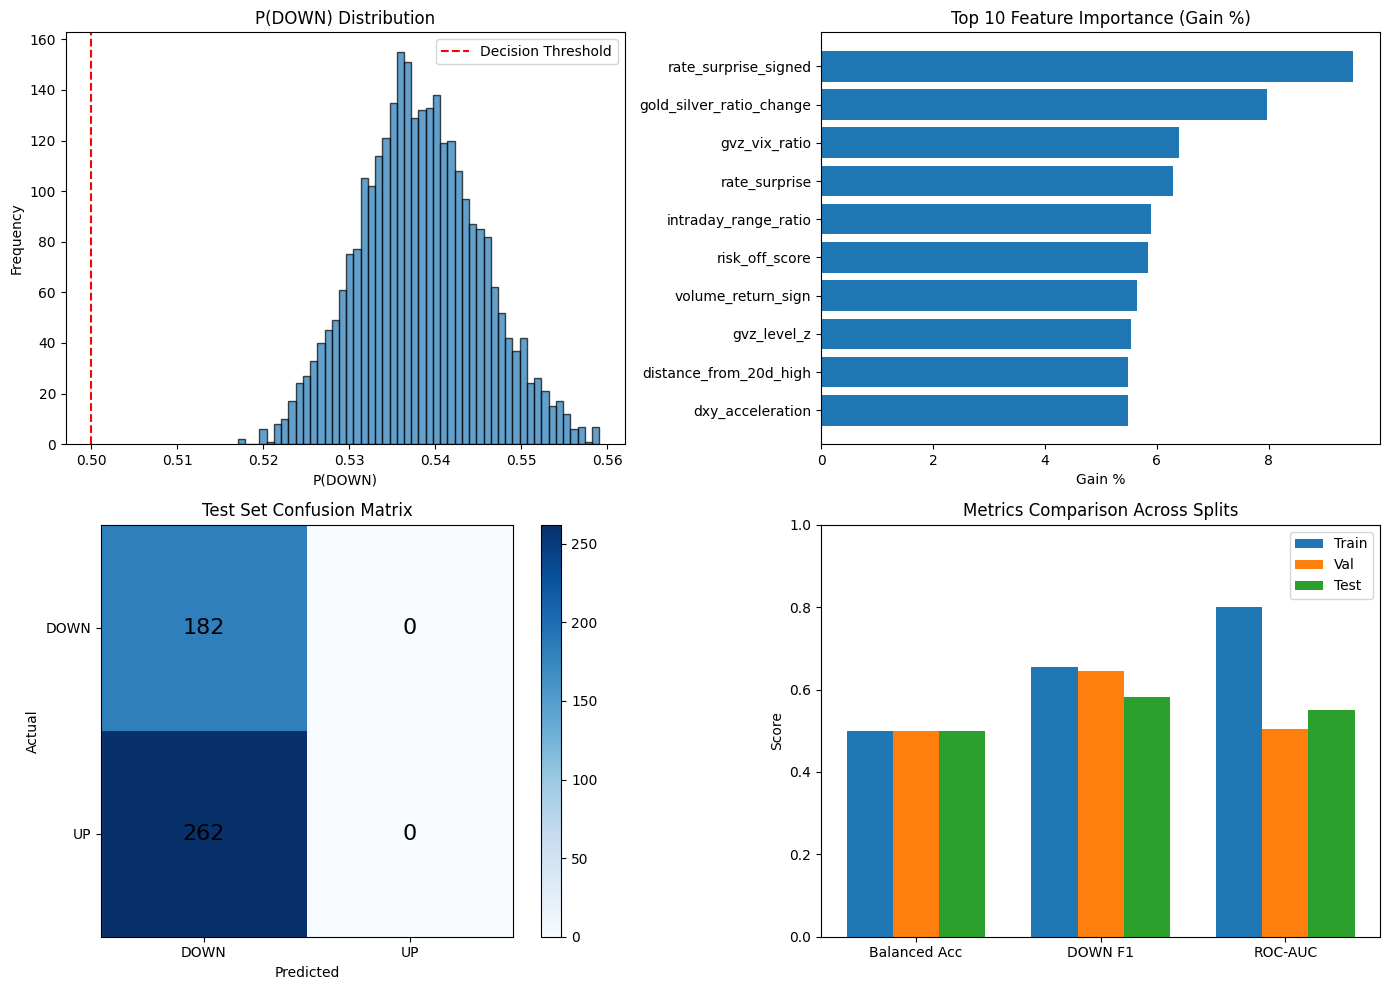

In [12]:
# Cell 12: Diagnostic Plots
print("\n" + "="*80)
print("DIAGNOSTIC PLOTS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. P(DOWN) distribution
axes[0, 0].hist(classifier_output['p_down'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('P(DOWN) Distribution')
axes[0, 0].set_xlabel('P(DOWN)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
axes[0, 0].legend()

# 2. Feature Importance
top_10 = importance_df.head(10)
axes[0, 1].barh(top_10['feature'], top_10['gain_pct'])
axes[0, 1].set_title('Top 10 Feature Importance (Gain %)')
axes[0, 1].set_xlabel('Gain %')
axes[0, 1].invert_yaxis()

# 3. Confusion Matrix (Test)
cm = confusion_matrix(y_test, test_pred)
im = axes[1, 0].imshow(cm, cmap='Blues')
axes[1, 0].set_title('Test Set Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xticks([0, 1])
axes[1, 0].set_yticks([0, 1])
axes[1, 0].set_xticklabels(['DOWN', 'UP'])
axes[1, 0].set_yticklabels(['DOWN', 'UP'])
for i in range(2):
    for j in range(2):
        text = axes[1, 0].text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=16)
plt.colorbar(im, ax=axes[1, 0])

# 4. Metrics Comparison
metrics_names = ['Balanced Acc', 'DOWN F1', 'ROC-AUC']
train_vals = [train_metrics['balanced_acc'], train_metrics['f1_down'], train_metrics['roc_auc']]
val_vals = [val_metrics['balanced_acc'], val_metrics['f1_down'], val_metrics['roc_auc']]
test_vals = [test_metrics['balanced_acc'], test_metrics['f1_down'], test_metrics['roc_auc']]

x = np.arange(len(metrics_names))
width = 0.25
axes[1, 1].bar(x - width, train_vals, width, label='Train')
axes[1, 1].bar(x, val_vals, width, label='Val')
axes[1, 1].bar(x + width, test_vals, width, label='Test')
axes[1, 1].set_title('Metrics Comparison Across Splits')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics_names)
axes[1, 1].legend()
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('diagnostics.png', dpi=100, bbox_inches='tight')
print("\nDiagnostic plots saved: diagnostics.png")
plt.show()